In [1]:
import sys
import os
import heapq
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image as im
from PIL.ImageShow import IPythonViewer
from scipy import ndimage
from matplotlib.pyplot import figure
from glob import glob
from tqdm import tqdm
from itertools import groupby
from random import randint
from string import punctuation
from razdel import tokenize

from typing import *

from utils import take_central_stripe, INTERVAL_FOR_STRIPE, binarize, avg

sep = os.path.sep
punctuation += "«»—…“”"
punct = set(punctuation)

In [2]:
with open(os.getcwd() + "/../dictation_text.txt") as f:
    text = f.read()
    dictation_text = [word.text.strip(punctuation) for word in tokenize(text)]

In [3]:
DATA_LOCATION = "../chopped"
WORK_PATHS = glob(f"{DATA_LOCATION}{sep}*{sep}*")
work_path = WORK_PATHS[0]
work_path

'../chopped/58198/58198_4'

In [4]:
# how close should notches be to form a single group of "consecutive" empty lines
NOTCHES_DIFF_THRESHOLD = 5
# how many consecutive empty lines should there be so that we count it as a notch
# We do not want to take a gap inside a word for a border between words
MIN_GROUP_SIZE_TO_CONDENSE = 10

def condense(notches) -> List[int]:
    condensed = []
    potential_group = []
    
    for notch in notches:
        if len(potential_group) == 0:
            potential_group.append(notch)
        elif notch - potential_group[-1] < NOTCHES_DIFF_THRESHOLD and notch != notches[-1]:
            potential_group.append(notch)
        else:
            # condense a group to one notch
            if len(potential_group) >= MIN_GROUP_SIZE_TO_CONDENSE:
                condensed.append(int(avg(potential_group)))
            potential_group = []
    return condensed

condense_notches = condense

In [5]:
def trim(image, where='lrtb', return_trims=False):
    bin_img = binarize(image)
    height, width = bin_img.shape
    def find_border(bin_img):
        for (idx, row) in enumerate(bin_img):
            if np.sum(row) > 1:
                return idx
    
    left = find_border(bin_img.T) if 'l' in where  else 0
    top = find_border(bin_img) if 'l' in where  else 0
    right = width - find_border(bin_img.T[::-1, :]) if 'r' in where else width
    bottom = height - find_border(bin_img[::-1, :]) if 'b' in where else height
    
    if return_trims:
        trims = {
            'l': left,
            't': top,
            'r': right,
            'b': bottom
        }
        return image.crop((left, top, right, bottom)), trims
    return image.crop((left, top, right, bottom))

In [6]:
class Line:
    def __init__(self, path: str):
        self.path = path
        self.image = im.open(path)
        self.bin_img = binarize(self.image)

    def __repr__(self):
        return f"Line({self.path})"
    
    def __lt__(self, other):
        return self.path[-6:-4] < other.path[-6:-4]

In [7]:
class Page:
    def __init__(self, path: str):
        self.path = path
        self.lines = [Line(l) for l in glob(path + "/*.png")]
        self.lines.sort()

    def __repr__(self):
        return f"Page({self.path})"
    
    def __lt__(self, other):
        return self.path[-1] < other.path[-1]

In [8]:
class Work:
    def __init__(self, work_path: str):
        self.pages = [Page(p) for p in glob(f"{work_path}{sep}*")]
        self.pages.sort()
        self.work_id = os.path.basename(work_path)

    @staticmethod
    def extract_work_id(filename: str) -> str:
        return filename.split('/')[-1].split('-')[0]
    
    def __repr__(self):
        return f"Work({self.work_id}, {self.pages})"
    

In [9]:
"""
Work(50382_33)

Причина: Обрезанный заголовок вместо строки 

Ошибка:
TypeError                                 Traceback (most recent call last)
Input In [117], in <cell line: 16>()
     13 h, w = line.bin_img.shape
     15 stripe = line.image.crop((0, h//2-INTERVAL_FOR_STRIPE, w, h//2+INTERVAL_FOR_STRIPE))
---> 16 trimmed_stripe, trims = trim(stripe, return_trims=True)
     17 bin_turned_around = binarize(trimmed_stripe)[::-1, :].T
     19 trimmed_line = line.image.crop((trims['l'],0,trims['r'],h))

Input In [82], in trim(image, where, return_trims)
      9 left = find_border(bin_img.T) if 'l' in where  else 0
     10 top = find_border(bin_img) if 'l' in where  else 0
---> 11 right = width - find_border(bin_img.T[::-1, :]) if 'r' in where else width
     12 bottom = height - find_border(bin_img[::-1, :]) if 'b' in where else height
     14 if return_trims:

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'
"""

"\nWork(50382_33)\n\nПричина: Обрезанный заголовок вместо строки \n\nОшибка:\nTypeError                                 Traceback (most recent call last)\nInput In [117], in <cell line: 16>()\n     13 h, w = line.bin_img.shape\n     15 stripe = line.image.crop((0, h//2-INTERVAL_FOR_STRIPE, w, h//2+INTERVAL_FOR_STRIPE))\n---> 16 trimmed_stripe, trims = trim(stripe, return_trims=True)\n     17 bin_turned_around = binarize(trimmed_stripe)[::-1, :].T\n     19 trimmed_line = line.image.crop((trims['l'],0,trims['r'],h))\n\nInput In [82], in trim(image, where, return_trims)\n      9 left = find_border(bin_img.T) if 'l' in where  else 0\n     10 top = find_border(bin_img) if 'l' in where  else 0\n---> 11 right = width - find_border(bin_img.T[::-1, :]) if 'r' in where else width\n     12 bottom = height - find_border(bin_img[::-1, :]) if 'b' in where else height\n     14 if return_trims:\n\nTypeError: unsupported operand type(s) for -: 'int' and 'NoneType'\n"

In [10]:
"""
Work(18956_21)

Причина: пустая строка каким-то образом прошла мимо фильтра на пустые строки в скрипте сегментации

Ошибка:
TypeError                                 Traceback (most recent call last)
Input In [158], in <cell line: 17>()
     14 h, w = line.bin_img.shape
     16 stripe = line.image.crop((0, axis(h)-INTERVAL_FOR_STRIPE, w, axis(h)+INTERVAL_FOR_STRIPE))
---> 17 trimmed_stripe, trims = trim(stripe, return_trims=True)
     18 bin_turned_around = binarize(trimmed_stripe)[::-1, :].T
     20 notches = []

Input In [82], in trim(image, where, return_trims)
      9 left = find_border(bin_img.T) if 'l' in where  else 0
     10 top = find_border(bin_img) if 'l' in where  else 0
---> 11 right = width - find_border(bin_img.T[::-1, :]) if 'r' in where else width
     12 bottom = height - find_border(bin_img[::-1, :]) if 'b' in where else height
     14 if return_trims:

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'
"""

"\nWork(18956_21)\n\nПричина: пустая строка каким-то образом прошла мимо фильтра на пустые строки в скрипте сегментации\n\nОшибка:\nTypeError                                 Traceback (most recent call last)\nInput In [158], in <cell line: 17>()\n     14 h, w = line.bin_img.shape\n     16 stripe = line.image.crop((0, axis(h)-INTERVAL_FOR_STRIPE, w, axis(h)+INTERVAL_FOR_STRIPE))\n---> 17 trimmed_stripe, trims = trim(stripe, return_trims=True)\n     18 bin_turned_around = binarize(trimmed_stripe)[::-1, :].T\n     20 notches = []\n\nInput In [82], in trim(image, where, return_trims)\n      9 left = find_border(bin_img.T) if 'l' in where  else 0\n     10 top = find_border(bin_img) if 'l' in where  else 0\n---> 11 right = width - find_border(bin_img.T[::-1, :]) if 'r' in where else width\n     12 bottom = height - find_border(bin_img[::-1, :]) if 'b' in where else height\n     14 if return_trims:\n\nTypeError: unsupported operand type(s) for -: 'int' and 'NoneType'\n"

In [11]:
work = Work(WORK_PATHS[randint(0, len(WORK_PATHS)-1)])
page = work.pages[randint(0, len(work.pages)-1)]
line = page.lines[randint(0, len(page.lines)-1)]
h, w = line.bin_img.shape

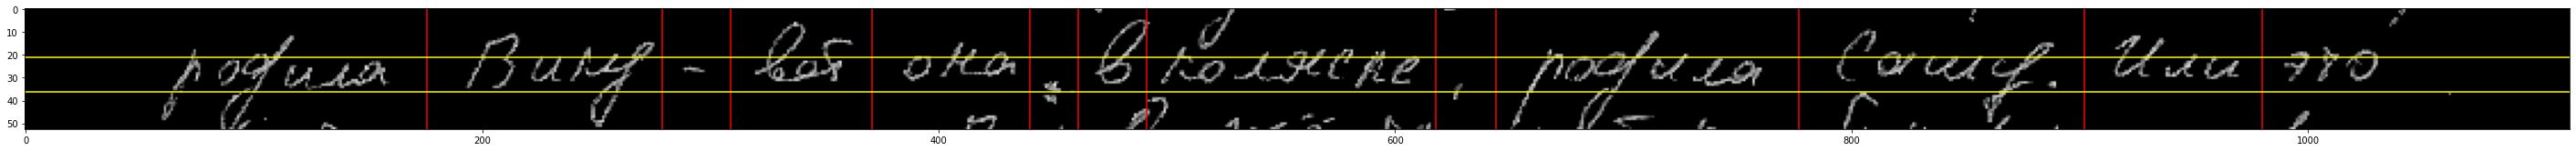

In [12]:
"""CONDENSED NOTCHES DEMO"""
work = Work(WORK_PATHS[randint(0, len(WORK_PATHS)-1)])
page = work.pages[randint(0, len(work.pages)-1)]
line = page.lines[randint(0, len(page.lines)-1)]
h, w = line.bin_img.shape

figure(figsize=(50, 50))
stripe = take_central_stripe(line.image,
                             up=5)
trimmed_stripe, trims = trim(stripe, return_trims=True)
bin_turned_around = binarize(trimmed_stripe)[::-1, :].T

notches = []
for idx, col in enumerate(bin_turned_around):
    if np.sum(col) == 0:
        notches.append(idx)

axis = h // 2
upper, lower = (axis-5, axis + INTERVAL_FOR_STRIPE)

condensed = condense(notches)
plt.imshow(line.bin_img, 'gray')
for x in condensed:
    x += trims['l']
    plt.axvline(x=x,color='red')

plt.axhline(y=upper,color='yellow')
plt.axhline(y=lower,color='yellow')


In [13]:
def segment_line_into_words(line: Line):
    
    stripe = take_central_stripe(line.image)
    try:
        trimmed_stripe, trims = trim(stripe, return_trims=True)
    except TypeError: 
        # somehow an empty line was not filtered. Usually due to image imperfections
        return []
    except:
        print(line)
        raise
    # easier to turn by 90 degrees and analyze row by row, which is same
    # as analyzing original image column by column
    bin_90_degrees = binarize(trimmed_stripe)[::-1, :].T

    notches = []
    for idx, col in enumerate(bin_90_degrees):
        if np.sum(col) == 0:
            notches.append(idx)        

    # dropping the empty space to the left and to the right of the line
    trimmed_line_image = line.image.crop((trims['l'], 0, trims['r'], line.image.height))
    condensed = [0] + condense(notches) + [trimmed_line_image.width]

    words = []
    pairs = [(condensed[i], condensed[i+1]) for i in range(len(condensed) - 1)]
    for l, r in pairs:
        words.append(trimmed_line_image.crop((l, 0, r, line.image.height)))
    return words

In [15]:
for work in tqdm((Work(path) for path in WORK_PATHS), total=526):
    for page in work.pages:
        for line in page.lines:
            line_num = os.path.basename(line.path).replace(".png", "")
            destination = f"../formatted_data/words/{work.work_id}/{os.path.basename(page.path)}/{line_num}"
            os.makedirs(destination, exist_ok=True)
            
            words = segment_line_into_words(line)
            for i, word in enumerate(words):
                word.convert("RGB").save(f"{destination}/{i}.jpg")

100%|█████████████████████████████████████████| 526/526 [05:53<00:00,  1.49it/s]


In [ ]:
""" HOUGH lines don't work """

# open_cv_image = np.array(words[1])[:, :, ::-1]
# open_cv_image = cv2.Canny(open_cv_image, 50, 200, None, 3)

# cdst = cv2.cvtColor(open_cv_image, cv2.COLOR_GRAY2BGR)
# cdstP = np.copy(cdst)

# lines = cv2.HoughLinesP(open_cv_image, 1, np.pi / 180, 50, None, 50, 10)
# print(lines)
# if lines is not None:
#     for i in range(0, len(lines)):
#         l = lines[i][0]
#         cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

# plt.imshow(cdstP)

In [ ]:
""" DELETE BY CONTOUR. DOESN'T WORK CUZ LETTERS CAN BE TOO SMALL"""

# %matplotlib inline
# figure(figsize=(20, 20))


# # Load image, convert to grayscale, Gaussian blur, Otsu's threshold
# image = np.array(line.image)[:, :, ::-1]
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray, (3,3), 3)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# # Filter using contour area and remove small noise
# cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     area = cv2.contourArea(c)
#     if area < 20:
#         cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# # Morph close and invert image
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# close = 255 - cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
# plt.imshow(thresh)

In [ ]:
""" FLOOD FILL ELEMENTS THAT ARE ON BORDER """

# figure(figsize=(20, 20))

# floodFilled = gray.copy()
# _, floodFilled = cv2.threshold(floodFilled, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
# for id in list(id for id, x in enumerate(floodFilled[1]) if x == 0):
#     cv2.floodFill(floodFilled, None,(id,1),255)
# plt.imshow(floodFilled, cmap="gray")